In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib.gridspec as gridspec
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")   # Fall back to CPU

CUDA is not available. Training on CPU.


In [5]:
# Data loader
BATCH_SIZE = 64
transformer = transforms.Compose([
    transforms.ToTensor()

])

minst_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transformer)
minst_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

#minst_total_size = len(minst_train_dataset)
#minst_train_size = int(minst_total_size * 0.7)
#minst_valid_size = minst_total_size - minst_train_size

#minst_train_set, minst_valid_set = random_split(minst_train_dataset, [minst_train_size, minst_valid_size])
#minst_train_loader = torch.utils.data.DataLoader(minst_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#minst_valid_loader = torch.utils.data.DataLoader(minst_valid_set, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
#minst_test_loader = torch.utils.data.DataLoader(minst_test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2)



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 6072182.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 161303.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:51<00:00, 31996.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9501510.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
class Discriminator(nn.Module):
    def __init__(self,h_dim,X_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            #nn.init.xavier_normal_(m.weight.data)
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
            
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        return self.model(x)

class Generator(nn.Module):
    def __init__(self,Z_dim,h_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 784),
            nn.Tanh()
        )
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            #nn.init.xavier_normal_(m.weight.data)
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
            
    def forward(self, z):
        return self.model(z)

    
# Conditional GAN models    
class CDiscriminator(nn.Module):
    
    def __init__(self,num_classes,h_dim,X_dim):
        super(CDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(X_dim + num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, x,y):
        c = self.label_emb(y)
        inputs = torch.cat([x, c], dim=1)
        return self.model(inputs)

class CGenerator(nn.Module):
    
    def __init__(self,num_classes,Z_dim,h_dim):
        super(CGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(Z_dim + num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 784),
            nn.Tanh()
        )
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, z,y):
        c = self.label_emb(y)
        inputs = torch.cat([z, c], dim=1)
        return self.model(inputs)

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def train(epochs, train_set, mb_size, Z_dim, G, D, d_optimizer, g_optimizer, criterion, device, g_name, d_name, ones_label, zeros_label):
    for epoch in range(epochs):
        
        z = torch.randn(mb_size, Z_dim).to(device)
        X, _ = train_set.data[torch.randint(len(train_set), (mb_size,))].view(-1, 784).float().div(255), train_set.targets[torch.randint(len(train_set), (mb_size,))]
        X = X.to(device)
        # Train Discriminator
        D_real = D(X)
        D_fake = D(G(z))

        D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

        D.zero_grad()
        
        D_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(mb_size, Z_dim).to(device)

        G_loss = -torch.mean(torch.log(D(G(z)) + 1e-8))

        G.zero_grad()
        
        G_loss.backward()
        g_optimizer.step()

        if (epoch+1) % 10000 == 0:
            print('Epoch-{}; D_loss: {:.4f}; G_loss: {:.4f}'.format(epoch+1, D_loss.item(), G_loss.item()))

            samples = G(z).data.cpu().detach().numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Save models
    torch.save(G.state_dict(), g_name)
    torch.save(D.state_dict(), d_name)

    
def train_con(epochs, train_set, mb_size, Z_dim, G, D, d_optimizer, g_optimizer, criterion, device, g_name, d_name, ones_label, zeros_label):
    for epoch in range(epochs):
        
        z = torch.randn(mb_size, Z_dim).to(device)
        idx = torch.randint(len(train_set), (mb_size,))
        X, y = train_set.data[idx].view(-1, 784).float().div(255).to(device), train_set.targets[idx].to(device)
        # Train Discriminator
        D_real = D(X, y)
        D_fake = D(G(z, y), y)

        D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

        D.zero_grad()        
        D_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(mb_size, Z_dim).to(device)

        G_loss = -torch.mean(torch.log(D(G(z, y), y) + 1e-8))

        G.zero_grad()       
        G_loss.backward()
        g_optimizer.step()

        if (epoch+1) % 10000 == 0:
            print('Epoch-{}; D_loss: {:.4f}; G_loss: {:.4f}'.format(epoch+1, D_loss.item(), G_loss.item()))

            samples = G(z, y).data.cpu().detach().numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Save models
    torch.save(G.state_dict(), g_name)
    torch.save(D.state_dict(), d_name)



In [7]:
def test_model(Z_dim, G, D, g_name, d_name, device,num_samples=16):
    G.load_state_dict(torch.load(g_name))
    #D.load_state_dict(torch.load(d_name))
    G.eval()
    #D.eval()

    # Generate fake samples
    with torch.no_grad():
        z = torch.randn(Z_dim, 100).to(device)
        fake_images = G(z)

    # Pass fake samples through the discriminator
    #with torch.no_grad():
    #    fake_pred = D(fake_samples)

    fig = plt.figure(figsize=(4, 4))
    for i in range(num_samples):
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(fake_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()
    

In [17]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)

g_name_st_10000 = 'generator.pth'
d_name_st_10000 = 'discriminator.pth'

G_10000 = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_10000 = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Optimizers
d_optimizer = optim.Adam(D_10000.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_10000.parameters(), lr=learning_rate, weight_decay=1e-5)

# Loss function
criterion = nn.BCELoss()

Epoch-10000; D_loss: 0.3986; G_loss: 3.7104
Epoch-20000; D_loss: 0.5417; G_loss: 2.7512
Epoch-30000; D_loss: 0.7354; G_loss: 1.9542
Epoch-40000; D_loss: 1.4017; G_loss: 1.0342
Epoch-50000; D_loss: 1.2989; G_loss: 0.7996
Epoch-60000; D_loss: 1.3541; G_loss: 1.0344
Epoch-70000; D_loss: 1.3949; G_loss: 1.2500
Epoch-80000; D_loss: 1.5699; G_loss: 0.6113
Epoch-90000; D_loss: 0.9011; G_loss: 2.1124
Epoch-100000; D_loss: 1.0171; G_loss: 1.7394


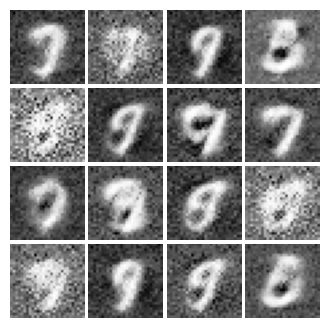

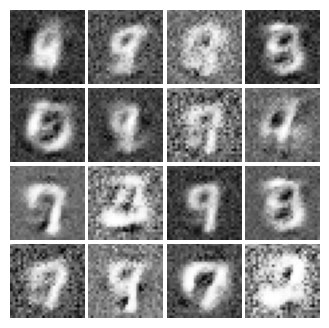

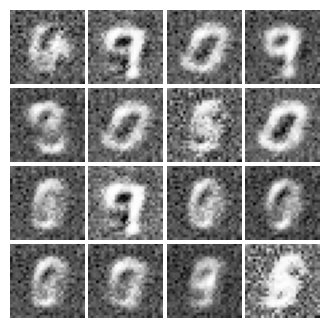

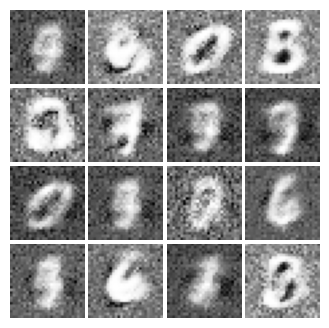

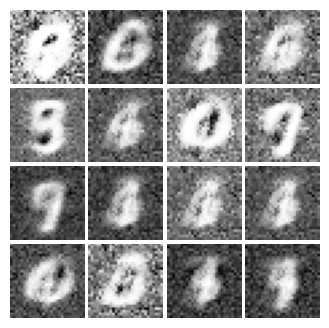

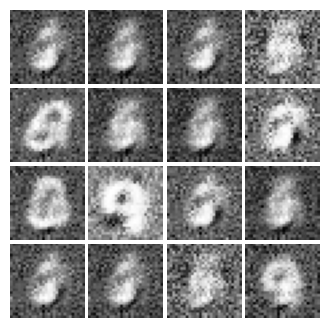

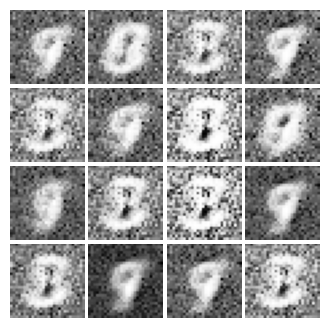

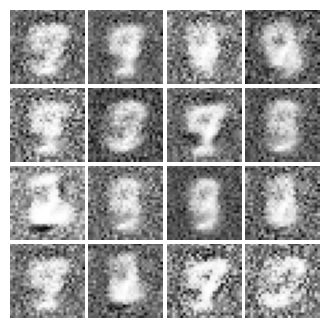

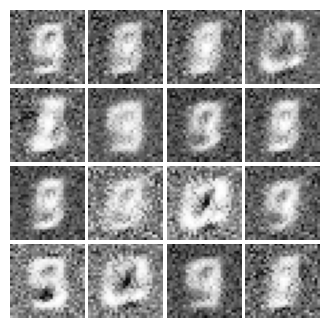

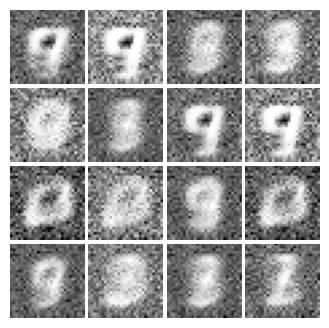

In [18]:
train(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_10000, D=D_10000,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_st_10000,
      d_name=d_name_st_10000,ones_label=ones_label,zeros_label=zeros_label)

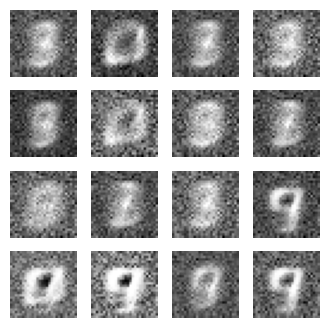

In [19]:
test_model(G=G_10000, D=D_10000,g_name=g_name_st_10000,d_name=d_name_st_10000,device=device,Z_dim=Z_dim)

In [20]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)
g_name_bce = 'generator_bce_2000.pth'
d_name_bce = 'discriminator_bce_2000.pth'

G_BCE = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_BCE = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
d_optimizer = optim.Adam(D_BCE.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_BCE.parameters(), lr=learning_rate, weight_decay=1e-5)

Epoch-10000; D_loss: 0.5335; G_loss: 2.8589
Epoch-20000; D_loss: 0.3761; G_loss: 3.4017


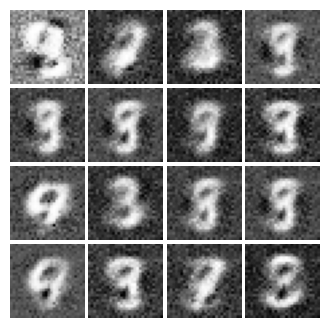

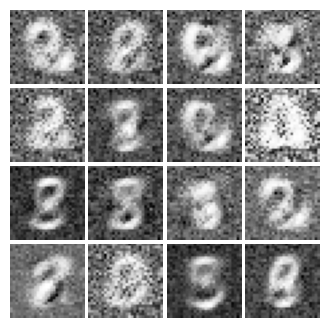

In [21]:
train(epochs=20000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_BCE, D=D_BCE,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_bce,
      d_name=d_name_bce,ones_label=ones_label,zeros_label=zeros_label)

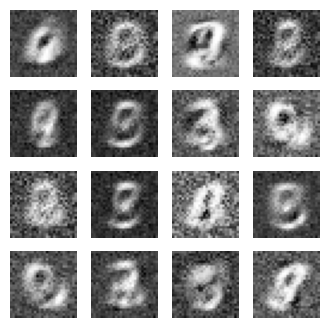

In [22]:
test_model(G=G_BCE, D=D_BCE,g_name=g_name_bce,d_name=d_name_bce,device=device,Z_dim=Z_dim)

In [24]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)
g_name_bce_100000 = 'generator_bce_100000.pth'
d_name_bce_100000 = 'discriminator_bce_100000.pth'

G_BCE_100 = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_BCE_100 = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
d_optimizer = optim.Adam(D_BCE_100.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G_BCE_100.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [25]:
train(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_BCE_100, D=D_BCE_100,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_bce_100000,
      d_name=d_name_bce_100000,ones_label=ones_label,zeros_label=zeros_label)

KeyboardInterrupt: 

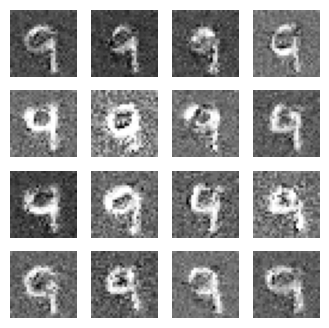

In [12]:
test_model(G=G_BCE_100, D=D_BCE_100,g_name=g_name_bce_100000,d_name=d_name_bce_100000,device=device,Z_dim=Z_dim)

In [26]:
# Conditional GAN
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]
num_classes  = len(minst_train_dataset.classes)

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)

g_name_con_10000 = 'con_generator.pth'
d_name_con_10000 = 'con_discriminator.pth'

G_con_10000 = CGenerator(num_classes=num_classes,Z_dim=Z_dim,h_dim=h_dim).to(device)
D_con_10000 = CDiscriminator(num_classes=num_classes,X_dim=X_dim,h_dim=h_dim).to(device)

# Optimizers
d_optimizer = optim.Adam(D_con_10000.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_con_10000.parameters(), lr=learning_rate, weight_decay=1e-5)

# Loss function
criterion = nn.BCELoss()


Epoch-10000; D_loss: 0.1312; G_loss: 4.6312
Epoch-20000; D_loss: 1.3990; G_loss: 4.6228
Epoch-30000; D_loss: 1.1650; G_loss: 1.1016
Epoch-40000; D_loss: 1.2698; G_loss: 1.0240
Epoch-50000; D_loss: 1.1271; G_loss: 0.9665
Epoch-60000; D_loss: 1.1753; G_loss: 1.1233
Epoch-70000; D_loss: 1.2841; G_loss: 0.6767
Epoch-80000; D_loss: 1.3105; G_loss: 0.8281
Epoch-90000; D_loss: 1.3613; G_loss: 0.8699
Epoch-100000; D_loss: 1.3564; G_loss: 0.8595


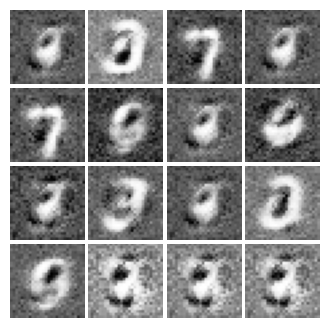

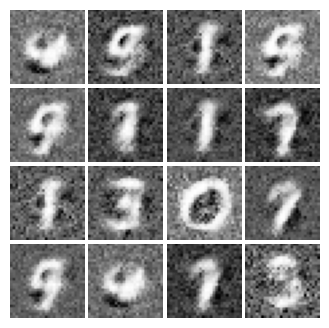

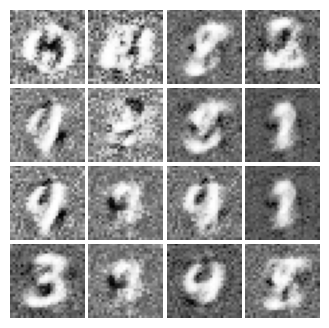

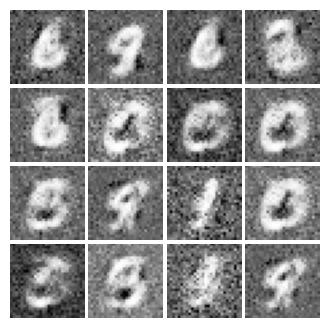

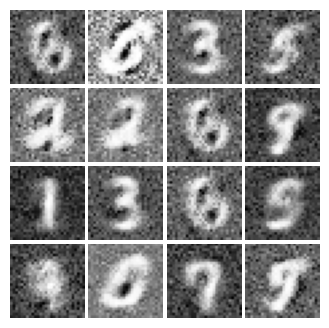

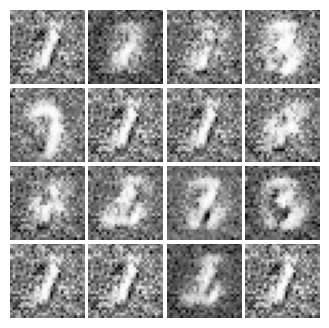

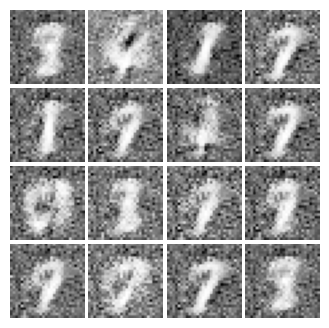

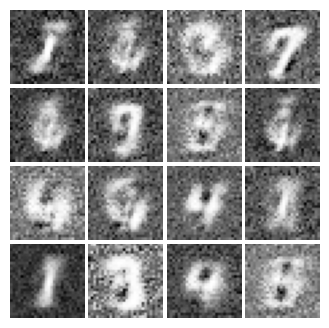

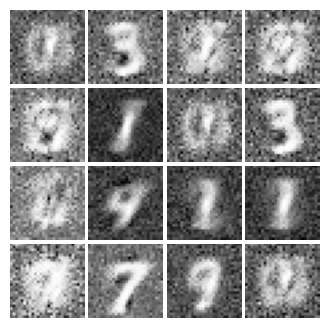

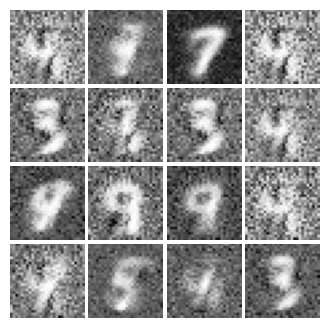

In [27]:
train_con(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_con_10000, D=D_con_10000,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_con_10000,
      d_name=d_name_con_10000,ones_label=ones_label,zeros_label=zeros_label)

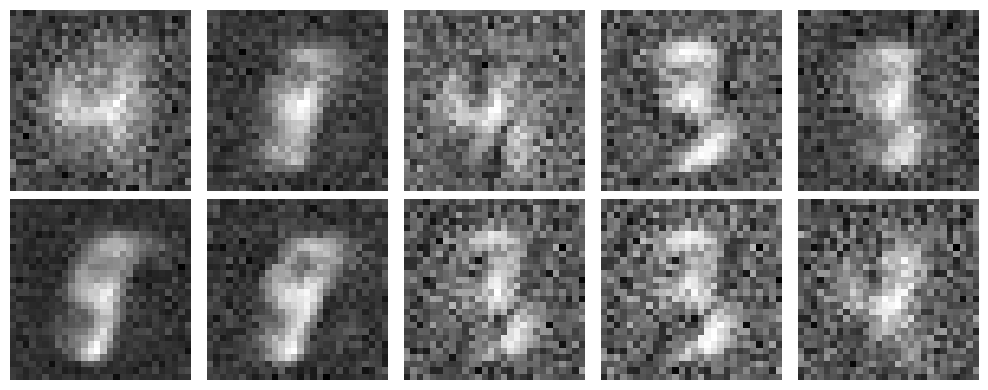

In [28]:
num_classes  = len(minst_train_dataset.classes)

# Load the trained generator model
generator = CGenerator(num_classes=num_classes,Z_dim=Z_dim,h_dim=h_dim).to(device)
generator.load_state_dict(torch.load(g_name_con_10000))
generator.eval()

# Number of images to generate
num_samples = 10


# Generate fake images
with torch.no_grad():
    z = torch.randn(num_samples, Z_dim, device=device)
    # Randomly select class labels
    y = torch.randint(0, num_classes, (num_samples,), device=device)
    fake_images = generator(z, y).cpu()

# Plot the generated images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].view(28, 28).numpy(), cmap='gray')  # Reshape to (28, 28)
    ax.axis('off')
plt.tight_layout()
plt.show()

The number to generate: 2


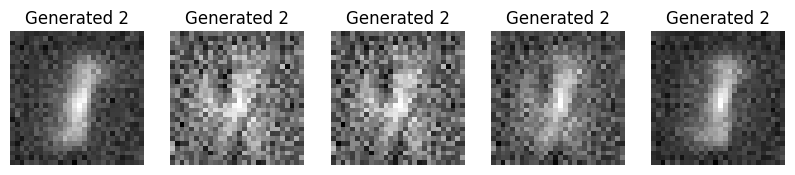

The number to generate: 3


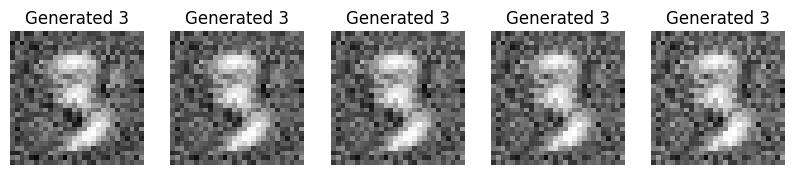

The number to generate: 5


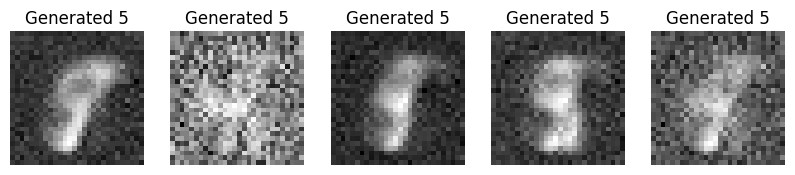

The number to generate: 8


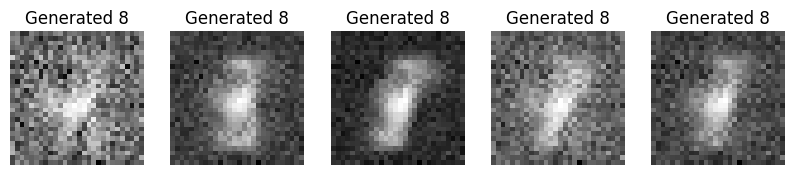

In [32]:
num_classes  = len(minst_train_dataset.classes)
generator = CGenerator(num_classes=num_classes,Z_dim=Z_dim,h_dim=h_dim).to(device)
generator.load_state_dict(torch.load(g_name_con_10000))
generator.eval()

# Generate sample images for a specific label
num_samples_per_label = 5
label_of_interest_list = [2,3,5,8] # Choose any number between 0-9

for label_of_interest in label_of_interest_list:
    print(f"The number to generate: {label_of_interest}")
    sample_labels = torch.tensor([label_of_interest] * num_samples_per_label)
    sample_z = torch.randn(num_samples_per_label, Z_dim)
    sample_images = generator(sample_z, sample_labels).detach().numpy()

    # Plot sample images
    fig, axes = plt.subplots(nrows=1, ncols=num_samples_per_label, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Generated {label_of_interest}')
    plt.show()

In [8]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
BATCH_SIZE = 64
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=True, transform=transform)


total_size = len(mnist_trainset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size


mnist_train_set, mnist_valid_set = random_split(mnist_trainset, [train_size, valid_size])
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 15847041.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 479697.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3779031.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14185054.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
model_cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
cnn_model_name =  'cnn.pth'
num_epochs = 2

In [10]:
# train model
def train(model,model_name, optimizer, criterion, train_loader, valid_loader, num_epochs,device):
    global writer
    train_loss_list = []
    valid_loss_list = []
    best_val_loss = np.inf
    best_model_sd = None
    model.to(device)
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0

        model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader)

        model.eval()

        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

        valid_loss = valid_loss / len(valid_loader)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_model_sd = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_sd)

    plt.plot(range(1,num_epochs + 1), train_loss_list)
    plt.plot(range(1,num_epochs + 1), valid_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")

    torch.save(model.state_dict(), model_name)

In [11]:
def test_model(model, model_name, test_loader,device):
    model.load_state_dict(torch.load(model_name))
    classes = ['0', '1', '2', '3',
               '4', '5', '6', '7', '8', '9']
    
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test accuracy of the network: {100 * correct // total} %')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

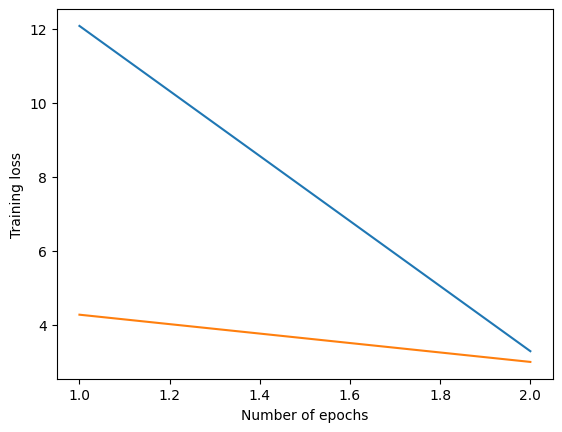

In [12]:
train(model_cnn,cnn_model_name,optimizer, criterion, mnist_train_loader,mnist_valid_loader, num_epochs, device)

Test accuracy of the network: 98 %


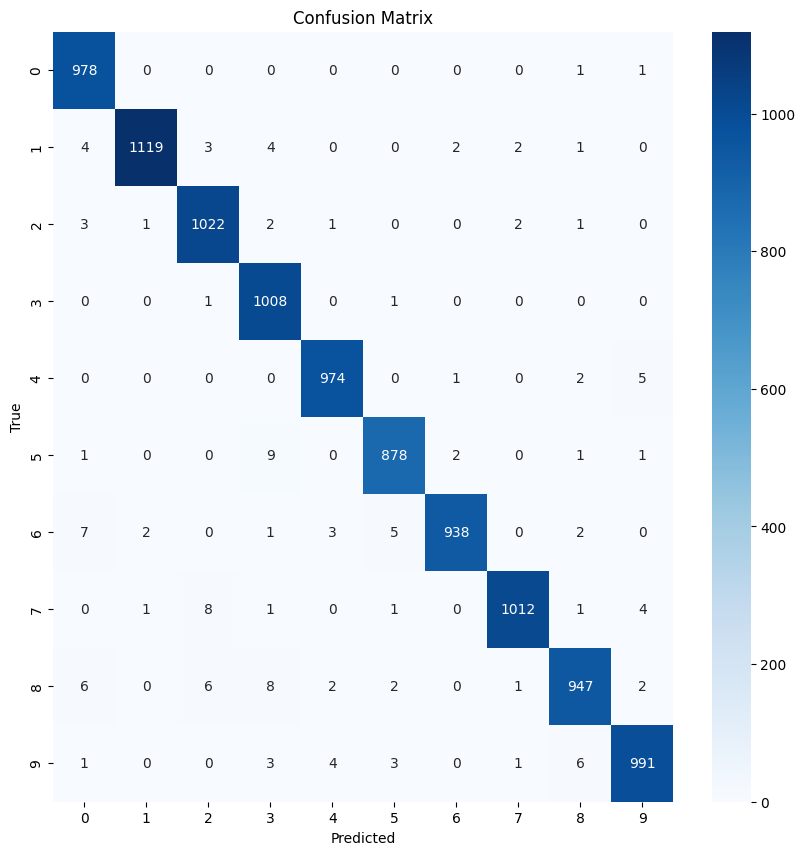

In [13]:
test_model(model_cnn,cnn_model_name,mnist_test_loader, device)

In [12]:
# Plot adversarial images
def plot_adv_examples(examples):
    plt.figure(figsize=(8, 10))
    for i in range(len(examples)):
        plt.subplot(1, len(examples), i+1)
        plt.tight_layout()
        plt.imshow(examples[i][2], cmap='gray')
        plt.title(f"Orig: {examples[i][0]}, Adv: {examples[i][1]}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [20]:
def generate_adversarial_images(image, label, model,cnn_model_name, epsilon=0.1):
    model.load_state_dict(torch.load(cnn_model_name))
    cnn_model_name
    image.requires_grad = True
    output = model(image)
    loss = torch.nn.NLLLoss()(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1) 
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('Original Image (Label: 4)')
    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('Adversarial Image (Label: 9)')
    plt.show()

In [15]:
sample_image, sample_label = mnist_trainset[0]
sample_image = sample_image.unsqueeze(0).to(device)

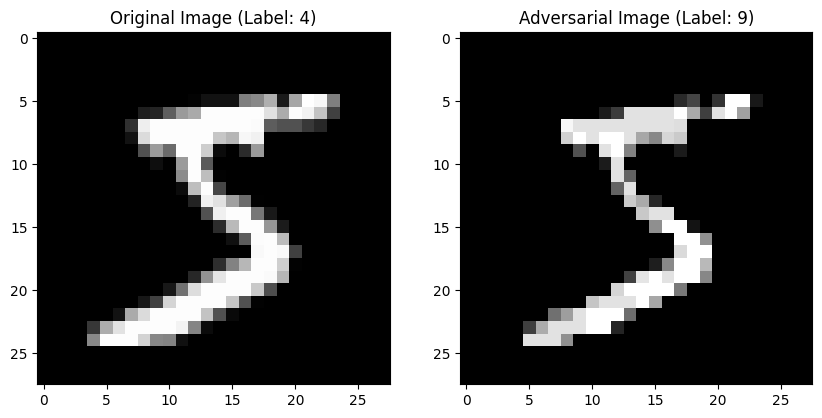

In [21]:
generate_adversarial_images(sample_image, torch.tensor([9]).to(device), model_cnn,cnn_model_name)